In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
import pandas_datareader as web
from sklearn.linear_model import LinearRegression 

In [2]:
symbols = ['CBA.AX', 'APT.AX', 'REA.AX', 'BHP.AX']

In [3]:
total_liab = []
total_asset = []
total_rev = []
net_income = []

In [5]:
for x in symbols:
    bs_idx = list(si.get_balance_sheet(x).index)
    pl_idx = list(si.get_income_statement(x).index)
    for i in bs_idx:
        if i == 'totalLiab':
            total_liab.append(si.get_balance_sheet(x).iloc[bs_idx.index(i),0])
        elif i == 'totalAssets':
            total_asset.append(si.get_balance_sheet(x).iloc[bs_idx.index(i),0])
    for j in pl_idx:
        if j == 'netIncome':
            net_income.append(si.get_income_statement(x).iloc[pl_idx.index(j),0])
        elif j == 'totalRevenue':
            total_rev.append(si.get_income_statement(x).iloc[pl_idx.index(j),0])

In [6]:
total_asset

[1014060000000, 1608526000.0, 1590523000, 104783000000]

In [7]:
total_liab

[942047000000, 662175000.0, 726030000, 52537000000]

In [8]:
total_rev

[21500000000, 476555000, 881857000, 42931000000]

In [9]:
net_income

[9634000000, -19780000, 112373000, 7956000000]

[13.08162415  0.69971395  0.83983329  1.0055698 ]


<AxesSubplot:>

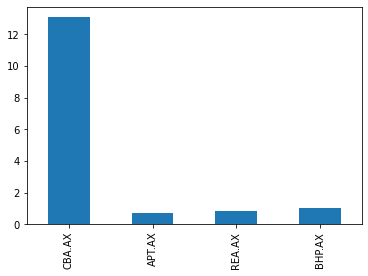

In [10]:
#Leverage Ratio
leverage = np.array(total_liab)/ (np.array(total_asset) - np.array(total_liab))
print(leverage)
pd.Series(leverage, index=symbols).plot(kind='bar')

<AxesSubplot:>

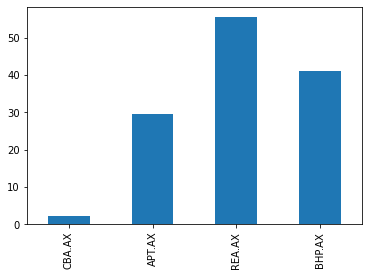

In [10]:
#Asset Turnover Ratio
total_asset_trnovr = (np.array(total_rev) / np.array(total_asset)) * 100
pd.Series(total_asset_trnovr, index=symbols).plot(kind='bar')

<AxesSubplot:>

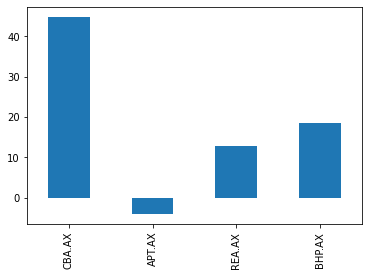

In [11]:
#Net Profit Margin
net_prof_mrgn = (np.array(net_income) / np.array(total_rev)) * 100
pd.Series(net_prof_mrgn, index=symbols).plot(kind='bar')

<AxesSubplot:>

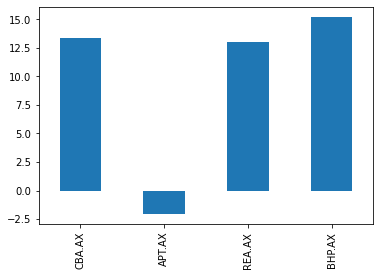

In [12]:
#ROE
roe = (np.array(net_income) / (np.array(total_asset) - np.array(total_liab))) * 100
pd.Series(roe, index=symbols).plot(kind='bar')

<AxesSubplot:>

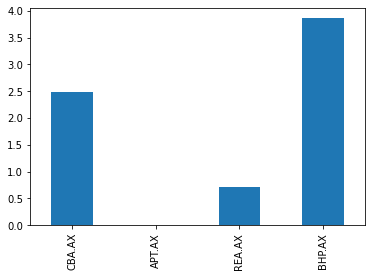

In [14]:
#Dividend Yield
div_yld = []
current = dt.datetime.today() - dt.timedelta(days=365)
for x in symbols:
    try:
        d = si.get_dividends(x)
        d = d.loc[d.index >= current,'dividend'].sum()
        p = si.get_live_price(x)
        div_yld.append((d/p).round(4)*100)
    except:
        div_yld.append(0)
        
pd.Series(div_yld, index=symbols).plot(kind='bar')

In [17]:
#Average Return
end = dt.datetime.today()
start = end - dt.timedelta(days=365)
stocks = web.get_data_yahoo(symbols, start=start, end=end)
stocks = stocks['Adj Close']
returns = stocks.pct_change().mean()*100
returns.plot(kind='bar')

RemoteDataError: No data fetched using 'YahooDailyReader'

年間リターン

In [26]:
returns = stocks.pct_change()
cum_rets = (returns + 1).cumprod()
annu_rets = (cum_rets.iloc[-1] - 1)
annu_rets

Symbols
CBA.AX    0.502909
APT.AX    1.096661
REA.AX    0.611952
BHP.AX    0.432274
Name: 2021-06-28 00:00:00, dtype: float64

<AxesSubplot:xlabel='Symbols'>

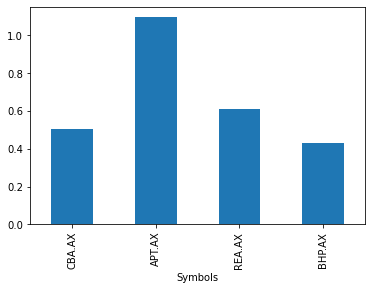

In [27]:
annu_rets.plot(kind='bar')

In [18]:
#毎日のリターンの合計しても年間のリターンにはならない　→　ログリターンの合計を用いる
cum_rets = returns.cumsum() 
cum_rets.iloc[-1]

Symbols
CBA.AX    0.429174
APT.AX    0.912255
REA.AX    0.519840
BHP.AX    0.396299
Name: 2021-06-28 00:00:00, dtype: float64

In [20]:
returns = np.log(stocks/stocks.shift(1))
#.apply(np.exp)を忘れないように
cum_rets = returns.cumsum().apply(np.exp)
cum_rets.iloc[-1] - 1

Symbols
CBA.AX    0.502909
APT.AX    1.096661
REA.AX    0.611952
BHP.AX    0.432274
Name: 2021-06-28 00:00:00, dtype: float64

In [21]:
(stocks.iloc[-1]/stocks.iloc[0]) - 1

Symbols
CBA.AX    0.502909
APT.AX    1.096661
REA.AX    0.611952
BHP.AX    0.432274
dtype: float64

ボラティリティ

<AxesSubplot:xlabel='Symbols'>

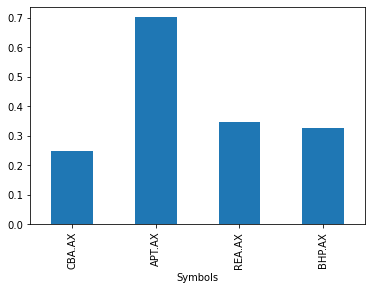

In [24]:
#年率換算する場合は365の平方根を掛ける
vola = returns.std()*(365**0.5)
vola.plot(kind='bar')

相関係数

In [24]:
corrcoef = returns.corr()
corrcoef

Symbols,CBA.AX,APT.AX,REA.AX,BHP.AX
Symbols,,,,
CBA.AX,1.000000,0.176641,0.315979,0.402559
APT.AX,0.176641,1.000000,0.455543,0.107291
REA.AX,0.315979,0.455543,1.000000,0.232993
BHP.AX,0.402559,0.107291,0.232993,1.000000


最大ドローダウン

In [25]:
max_dd = []
for x in symbols:
    price = web.get_data_yahoo(x, start=start, end=end)['Adj Close']
    cum_ret = price.pct_change().cumsum().dropna() #リターンの累積和
    trough = (np.maximum.accumulate(cum_ret) - cum_ret).idxmax()
    peak = cum_ret[:trough].idxmax()
    dd = (cum_ret[trough] - cum_ret[peak]) * 100
    max_dd.append(dd)
max_dd

[-15.233135158078825,
 -58.61291282622256,
 -18.701205165819268,
 -14.75117624057799]

In [30]:
max_dd = []
for x in symbols:
    price = web.get_data_yahoo(x, start=start, end=end)['Adj Close']
    trough = (np.maximum.accumulate(price) - price).idxmax() #価格
    peak = price[:trough].idxmax()
    dd = (price[trough] / price[peak] - 1) * 100
    max_dd.append(dd)
max_dd

[-14.378408165493884,
 -46.677605004674795,
 -17.3572381944608,
 -11.69409629639806]

主要データの比較

In [28]:
list = []
for x in symbols:
    list.append(si.get_stats(x))
    stats = pd.concat(list, axis=1, join='outer')
stats.index = stats['Attribute']
stats = stats.drop(columns='Attribute')
stats.columns = symbols
stats.index = si.get_stats(symbols[0])['Attribute']
stats

,CBA.AX,APT.AX,REA.AX,BHP.AX
Attribute,,,,
Beta (5Y Monthly),0.68,1.97,1.01,0.84
52-Week Change 3,42.05%,98.09%,48.65%,27.97%
S&P500 52-Week Change 3,33.06%,33.06%,33.06%,33.06%
52 Week High 3,106.57,160.05,173.11,51.82
52 Week Low 3,62.64,55.30,102.60,33.73
50-Day Moving Average 3,98.55,97.14,159.75,48.64
200-Day Moving Average 3,88.71,116.31,150.31,46.50
Avg Vol (3 month) 3,2.38M,1.47M,155.24k,5.32M
Avg Vol (10 day) 3,4.44M,1.54M,253.6k,7.9M


ベータ

In [28]:
end = dt.datetime.today()
start = end - dt.timedelta(days=365)

In [29]:
cba = si.get_data('CBA.AX', start_date=start, end_date=end)['adjclose'].pct_change().dropna()
aord = si.get_data('^AORD', start_date=start, end_date=end)['adjclose'].pct_change().dropna()

In [30]:
cba = cba.values.reshape(-1, 1)
aord = aord.values

In [31]:
model = LinearRegression().fit(cba, aord)

In [32]:
model.coef_

array([0.51591408])